In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import sys
sys.path.append("../")
from pathlib import Path
from argparse import ArgumentParser
warnings.filterwarnings('ignore')

# torch and lightning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pytorch_lightning as pl
from torchvision import transforms

from pytorch_lightning.loggers import WandbLogger

import os
import pycimg
from glob import glob

import cv2

import numpy as np
import matplotlib.pyplot as plt
import random
import json
import datetime
from matplotlib.backends.backend_pdf import PdfPages
import zlib
from PIL import Image
from tqdm import tqdm


np.set_printoptions(precision=2)

In [2]:
def loadRayosX(f,maxval=2**16-1,sigma=2):
    
    if "LOW" in f:
        namelow=f
        namehigh=f.replace("LOW","HI_ORI")
    else:
        namehigh=f
        namelow=f.replace("HI_ORI","LOW")
        
    imlow=cv2.imread(namelow,cv2.IMREAD_UNCHANGED)
    imhigh=cv2.imread(namehigh,cv2.IMREAD_UNCHANGED)
    
    imlow=imlow.astype(np.float32)
    imhigh=imhigh.astype(np.float32)
    
    if maxval is not None:
        imlow/=maxval
        imhigh/=maxval
    img=np.stack([imlow,imhigh,0*imlow],axis=2)
    tam=2*round(3*sigma)+1
    imgfilt=cv2.GaussianBlur(img,(tam,tam),sigma)
    zeff=Zeff(imgfilt,maxval)
    img[:,:,2]=zeff 
    imgfilt[:,:,2]=zeff
    return imgfilt,img

def Zeff(low_high,maxval):
    blancos_low=59860
    blancos_high=58500
    low=low_high[:,:,0]*maxval
    high=low_high[:,:,1]*maxval
    mascara=(low<blancos_low*0.9)*(high<blancos_high*0.9)
    zeff=np.zeros_like(low)
    zeff[mascara]=np.log(low[mascara]/blancos_low)/np.log(high[mascara]/blancos_high)
    zeff/=2
    zeff=np.clip(zeff,0,1)
    #zeff=np.log(low)/np.log(high)
    return zeff

In [3]:
def rotationMatrix(im,threshold=0.85,min_area=150000):
    binaria=(im<threshold)
   
    cont,_=cv2.findContours(binaria.astype(np.uint8),cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    #cont2=[]
    max_area=0
    indice_max_area=0
    for c in cont:
        area=cv2.contourArea(c)
        if area<min_area:
            continue
        if area>max_area:
            max_area=area
            indice_max_area=c

    cont2=indice_max_area
   
    momentos=cv2.moments(cont2)
    #print('type cont2',cont2[0].dtype)
    bb=cv2.boundingRect(cont2)
    
    #print('boundingbox',bb)
    centro_bb=np.array(bb[0:2])+np.array(bb[2:])/2
    #print(momentos)
    area=momentos['m00']
    centro=[momentos['m10']/area,momentos['m01']/area]
    mc=[[momentos['mu20'],momentos['mu11']],[momentos['mu11'],momentos['mu02']]]
    autovalores,autovectores=np.linalg.eig(mc)
    orden=np.argsort(autovalores)
    indice=orden[-1]
    #print('centro',centro)
    vector=autovectores[:,indice]
    #print('vector',vector)
    final=centro+vector*400
    inicio=centro-vector*400
    angulo1=np.arctan2(vector[1],vector[0])*180/np.pi
    #print('angulo1',angulo1)
    vcentros=centro_bb-centro
    if np.dot(vcentros,vector)>0:
        angulo_rotacion=angulo1+180+90
    else:
        angulo_rotacion=angulo1+90
    escala=np.sqrt(370000/area)
    rotation_matrix = cv2.getRotationMatrix2D((0,0),angulo_rotacion,escala) 
    # print('rotation matrix shape',rotation_matrix.shape)
    m1=np.array([[1,0,-centro[0]],[0,1,-centro[1]],[0,0,1]])
    m2=np.array([[1,0,500],[0,1,600],[0,0,1]])
    m3=np.eye(3)
    m3[0:2,0:2]=rotation_matrix[0:2,0:2]
    rotation_matrix=m2@m3@m1
    # print('angulo rotacion',angulo_rotacion)
    # print(mc)
    return rotation_matrix,bb
    

In [4]:
def bounding_box(recorte,threshold=0.85,orla=2,min_area=150000):
    recorte_binaria=recorte<threshold
    # plt.imshow(recorte_binaria)
    contr,_=cv2.findContours(recorte_binaria.astype(np.uint8),cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    contr2=[]
    max_area=0
    indice_max_area=0
    for c in contr:
        area=cv2.contourArea(c)
        if area<min_area:
            continue
        if area>max_area:
            max_area=area
            indice_max_area=c
        #contr2.append(c)
        #print(cv2.contourArea(c))
    contr2=indice_max_area
    #assert len(contr2)==1
  
    bb_recorte=cv2.boundingRect(contr2)
    
    bb_recorte=np.array(bb_recorte)
    bb_recorte[:2]-=orla
    bb_recorte[-2:]+=2*orla
    return bb_recorte

In [5]:
def alinea(imagen,threshold=0.85,orla=2,min_area=150000):
    #print(imagen.shape)
    im_low=imagen[:,:,0]
    rotation_matrix,bb=rotationMatrix(im_low,threshold=threshold,min_area=min_area)
    recorte=cv2.warpAffine(imagen,rotation_matrix[0:2,:],borderMode=cv2.BORDER_REPLICATE,dsize=(1000,1200))
 
    # recorte=rotated_image[int(1000-600):int(1000+600),int(1000-500):int(1000+500)]
    if bb[0]<5 or bb[1]<5 or bb[0]+bb[2]>imagen.shape[1]-5 or bb[1]+bb[3]>imagen.shape[0]-5:
        print('IMAGEN CERCA DEL BORDE')
        return None
    bb_recorte=bounding_box(recorte[:,:,0],threshold,0,min_area)
    # plt.imshow(recorte)
    # plt.title('recorte')

    xini=bb_recorte[0]
    yini=bb_recorte[1]
    xfin=xini+bb_recorte[2]
    yfin=yini+bb_recorte[3]
  
    # if xini<5 or yini<5 or xfin>recorte.shape[1]-5 or yfin>recorte.shape[0]-5:
    #     print('IMAGEN CERCA DEL BORDE')
    #     return None
    im_final=recorte[yini:yfin,xini:xfin,:]
    im_margen=np.pad(im_final,pad_width=((orla,orla),(orla,orla),(0,0)),mode='edge')
    
    return im_margen

Text(0.5, 1.0, 'LOW')

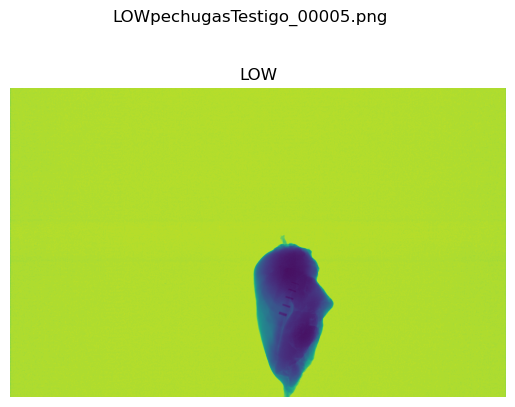

In [10]:
i='/mnt/d/mscanData/rayosX/pollo/20240708_073122_pechugasTestigo/LOWpechugasTestigo_00005.png'
image=cv2.imread(i,cv2.IMREAD_UNCHANGED)
image=image.astype(np.float32)
plt.suptitle(os.path.basename(i))
plt.imshow(image) #Low, High, Zeff
plt.axis('off')
plt.title('LOW')

In [11]:
print(i)
maxval=2**16-1
z=loadRayosX(i,maxval=maxval)[0] #(H,W,3) #low, high, zeff
im_final =alinea(z,threshold=0.8,orla=15,min_area=100000)
if im_final is None:
    print('Imagen cerca del borde')
else:
    plt.imshow(im_final)
    print(im_final.shape)
    tam_150=cv2.resize(im_final,(150,150),interpolation=cv2.INTER_AREA)

/mnt/d/mscanData/rayosX/pollo/20240708_073122_pechugasTestigo/LOWpechugasTestigo_00005.png
IMAGEN CERCA DEL BORDE
Imagen cerca del borde


Text(0.5, 1.0, 'LOW')

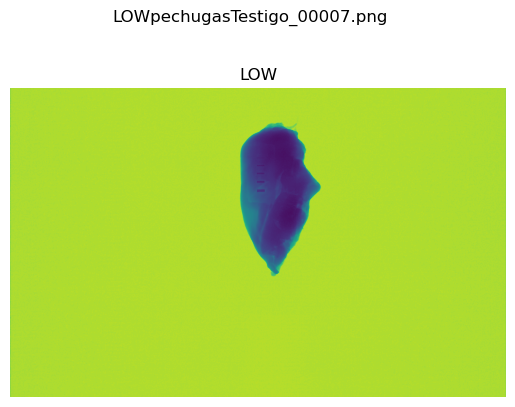

In [12]:
i='/mnt/d/mscanData/rayosX/pollo/20240708_073122_pechugasTestigo/LOWpechugasTestigo_00007.png'
image=cv2.imread(i,cv2.IMREAD_UNCHANGED)
image=image.astype(np.float32)
plt.suptitle(os.path.basename(i))
plt.imshow(image) #Low, High, Zeff
plt.axis('off')
plt.title('LOW')

/mnt/d/mscanData/rayosX/pollo/20240708_073122_pechugasTestigo/LOWpechugasTestigo_00007.png
(1048, 558, 3)


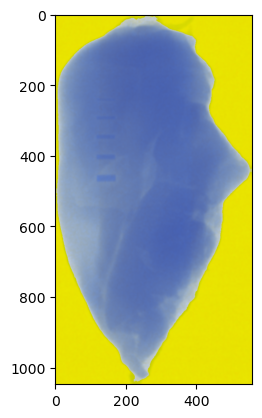

In [13]:
print(i)
maxval=2**16-1
z=loadRayosX(i,maxval=maxval)[0] #(H,W,3) #low, high, zeff
im_final =alinea(z,threshold=0.8,orla=5,min_area=100000)
if im_final is None:
    print('Imagen cerca del borde')
else:
    plt.imshow(im_final)
    print(im_final.shape)
    tam_150=cv2.resize(im_final,(150,150),interpolation=cv2.INTER_AREA)

# Entremuslos

In [14]:
dir_entremuslos="mscanData/rayosX/pollo/"
user=os.getenv('USER')
if user=='csanchis':
    dir_entremuslos=os.path.join("/mnt/d",dir_entremuslos)
elif user=="aalbiol":
    dir_entremuslos=os.path.join("/home/aalbiol/owc",dir_entremuslos)

pgl=glob(dir_entremuslos+"/*/*LOWentremuslo*.png")
print(len(pgl))
print(pgl[0])
print(os.path.dirname(pgl[0]))

206
/mnt/d/mscanData/rayosX/pollo/20240708_073400_entremusloGood/LOWentremusloGood_00001.png
/mnt/d/mscanData/rayosX/pollo/20240708_073400_entremusloGood


In [15]:
maxval=2**16-1
for im in tqdm(pgl):
    recortadas_dir=os.path.join(os.path.dirname(im),'images')
    recortadas_dir_150=os.path.join(os.path.dirname(im),'images_150')
    #print('im',im)
    if not os.path.exists(recortadas_dir):
        os.makedirs(recortadas_dir)
    if not os.path.exists(recortadas_dir_150):
        os.makedirs(recortadas_dir_150)
    z=loadRayosX(im,maxval=maxval)[0] #(H,W,3) #low, high, zeff
    im_final =alinea(z,threshold=0.8,orla=15,min_area=100000)
    if im_final is None:
        print('Imagen muy cerca del borde: Ignorada')
        print('Nombre: ', im)
    else:
        #print(im_final.shape)
        tam_150=cv2.resize(im_final,(150,150),interpolation=cv2.INTER_AREA)
        im_name=im.replace('LOW','')
        dir_completo=os.path.join(recortadas_dir,os.path.basename(im_name))
        dir_completo_150=os.path.join(recortadas_dir_150,os.path.basename(im_name))
        cv2.imwrite(dir_completo,(im_final*2**16-1).astype(np.uint16))
        cv2.imwrite(dir_completo_150,(tam_150*2**16-1).astype(np.uint16))

 56%|█████▋    | 116/206 [01:39<01:13,  1.22it/s]

IMAGEN CERCA DEL BORDE
Imagen muy cerca del borde: Ignorada
Nombre:  /mnt/d/mscanData/rayosX/pollo/20240708_073400_entremusloGood/LOWentremusloGood_00116.png


100%|██████████| 206/206 [02:55<00:00,  1.17it/s]


# Pechuga

In [16]:
dir_pechugas="mscanData/rayosX/pollo/"
user=os.getenv('USER')
if user=='csanchis':
    dir_pechugas=os.path.join("/mnt/d",dir_pechugas)
elif user=="aalbiol":
    dir_pechugas=os.path.join("/home/aalbiol/owc",dir_pechugas)

pgl=glob(dir_pechugas+"/*/*LOWpechuga*.png")
print(len(pgl))
print(pgl[0])
print(os.path.dirname(pgl[0]))

166
/mnt/d/mscanData/rayosX/pollo/20240708_072803_pechugasGood/LOWpechugasGood_00001.png
/mnt/d/mscanData/rayosX/pollo/20240708_072803_pechugasGood


In [17]:
maxval=2**16-1
for im in tqdm(pgl):
    recortadas_dir=os.path.join(os.path.dirname(im),'images')
    recortadas_dir_150=os.path.join(os.path.dirname(im),'images_150')
    #print('im',im)
    if not os.path.exists(recortadas_dir):
        os.makedirs(recortadas_dir)
    if not os.path.exists(recortadas_dir_150):
        os.makedirs(recortadas_dir_150)
    z=loadRayosX(im,maxval=maxval)[0] #(H,W,3) #low, high, zeff
    im_final =alinea(z,threshold=0.8,orla=15,min_area=200000)
    if im_final is None:
        print('Imagen muy cerca del borde: Ignorada')
        print('Nombre: ', im)
    else:
        #print(im_final.shape)
        tam_150=cv2.resize(im_final,(150,150),interpolation=cv2.INTER_AREA)
        im_name=im.replace('LOW','')
        dir_completo=os.path.join(recortadas_dir,os.path.basename(im_name))
        dir_completo_150=os.path.join(recortadas_dir_150,os.path.basename(im_name))
        cv2.imwrite(dir_completo,(im_final*2**16-1).astype(np.uint16))
        cv2.imwrite(dir_completo_150,(tam_150*2**16-1).astype(np.uint16))

  3%|▎         | 5/166 [00:04<02:22,  1.13it/s]

IMAGEN CERCA DEL BORDE
Imagen muy cerca del borde: Ignorada
Nombre:  /mnt/d/mscanData/rayosX/pollo/20240708_072803_pechugasGood/LOWpechugasGood_00005.png


  4%|▎         | 6/166 [00:05<02:14,  1.19it/s]

IMAGEN CERCA DEL BORDE
Imagen muy cerca del borde: Ignorada
Nombre:  /mnt/d/mscanData/rayosX/pollo/20240708_072803_pechugasGood/LOWpechugasGood_00006.png


 43%|████▎     | 71/166 [00:59<01:10,  1.34it/s]

IMAGEN CERCA DEL BORDE
Imagen muy cerca del borde: Ignorada
Nombre:  /mnt/d/mscanData/rayosX/pollo/20240708_073122_pechugasTestigo/LOWpechugasTestigo_00005.png


 43%|████▎     | 72/166 [01:00<01:07,  1.40it/s]

IMAGEN CERCA DEL BORDE
Imagen muy cerca del borde: Ignorada
Nombre:  /mnt/d/mscanData/rayosX/pollo/20240708_073122_pechugasTestigo/LOWpechugasTestigo_00006.png


 93%|█████████▎| 154/166 [02:04<00:10,  1.12it/s]

IMAGEN CERCA DEL BORDE
Imagen muy cerca del borde: Ignorada
Nombre:  /mnt/d/mscanData/rayosX/pollo/20240710_085313_pechugaGood/LOWpechugaGood_00022.png


100%|██████████| 166/166 [02:15<00:00,  1.22it/s]
